<a target="_blank" href="https://colab.research.google.com/github/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2020%20-%20Language%20Models%20with%20Hugging%20Face/Lecture%2020%20-%20Language%20Models%20with%20Hugging%20Face.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a name='section0'></a>
# Lecture 21 Model Selection

- [21.1 Model Selection](#section1)
- [21.2 Evaluate the Impact of Learning Rate](#section2)
    - [21.2.1 Learning Rate Finder](#section2-1)
- [21.3 Callbacks](#section3)
- [21.4 Grid Search](#section4) 
- [21.5 Keras Tuner](#section5)    
- [21.6 AutoML](#section6) 
- [References](#section10)






<a name='section1'></a>

# 20.1 Model Selection

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:

Model hyperparameters which influence model selection such as the number and width of hidden layers
Algorithm hyperparameters which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier
In this tutorial, you will use the Keras Tuner to perform hypertuning for an image classification application.

<a name='section2'></a>

# 21.2 Evaluate the Impact of Learning Rate

### Loading the Dataset

For this lecture, we will use a dataset of 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img,  img_to_array
import os
from os import listdir
import csv
import natsort 

# Print the version of tf
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.9.2
Keras version:2.9.0


In [3]:
# Path to the directory containing the dataset
!unzip -uq 'drive/MyDrive/Data_Science_Course/Lecture_21-Model_Selection,Tuning/data/LFW-dataset.zip' -d 'sample_data/'

Images train shape: (3043, 100, 100, 3) - Labels train shape: (3043,)
Images validation shape: (1021, 100, 100, 3) - Labels validation shape: (1021,)
Images test shape: (1049, 100, 100, 3) - Labels test shape: (1049,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4739037699151936
Data type float64


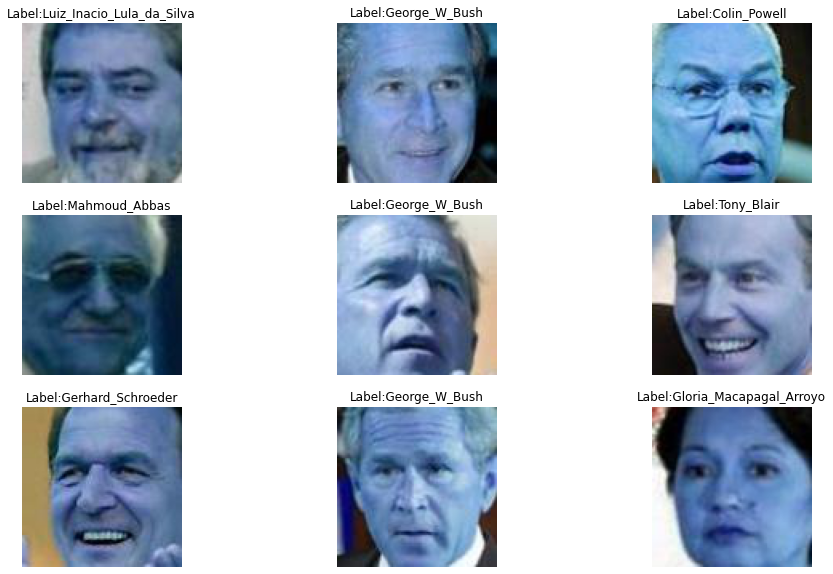

In [4]:
# Function for loading the images
def load_imgs(path):
    # List of all images in the folder
    imgList = listdir(path)
    # Make sure that the images are sorted in ascending order
    imgList=natsort.natsorted(imgList)
    # Number of images
    number_imgs = len(imgList)
    # Initialize numpy arrays for the images
    images = np.zeros((number_imgs, image_size, image_size, 3))
    # Read the images
    for i in range(number_imgs):
        tmp_img = load_img(path + imgList[i], target_size=(image_size, image_size, 3))
        img = img_to_array(tmp_img)
        images[i] = img/255.0
    return images

# Directories
train_dir = 'sample_data/LFW-dataset/Train/'
test_dir = 'sample_data/LFW-dataset/Test/'
val_dir = 'sample_data/LFW-dataset/Validation/'
labels_dir = 'sample_data/LFW-dataset/'

# Size of images (pixel width and height)
image_size = 100

# Call the above function to load the images as numpy arrays
imgs_train = load_imgs(train_dir)
imgs_test = load_imgs(test_dir)
imgs_val = load_imgs(val_dir)

# Load the labels as numpy arrays
labels_train = np.genfromtxt(labels_dir + "train_labels.csv", delimiter=',', dtype=np.int32)
labels_test = np.genfromtxt(labels_dir + "test_labels.csv", delimiter=',', dtype=np.int32)
labels_val = np.genfromtxt(labels_dir + "val_labels.csv", delimiter=',', dtype=np.int32)

# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

# Read the names of the celebrities in the dataset (there are 62 celebrities)
name_list = []
with open(labels_dir+'name_list.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        name_list.append(row[1])

# Plot a few images to check if the the labels are correct
# There are a few bad images in the dataset, it needs to be cleaned
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(name_list[labels_train[i[0]]]))
    plt.axis('off')

### Define the Model

In [5]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import vgg16

import datetime
now = datetime.datetime.now

In [6]:
def Network():

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer
    predictions = Dense(62, activation='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

Let's define a function for plotting the accuracy and loss called `plot_accuracy_loss`, which we can call with different models to examine the learning curves. 

In [7]:
def plot_accuracy_loss():
    # plot the accuracy and loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 

### Learning rate = 1e-4, Epochs = 10

The following code trains a model for 10 epochs with a learning rate of `1e-4 = 0.0001`. We have selected this learning rate because we know that it works well for this combination of model and data.

We can see that the model achieved 87.51% accuracy on the test set, and the training took about 2 minutes. From the plots of the accuracy and loss curves, we can tell that 10 epochs were not sufficient for training the model, because at the end of the 10th epoch, the accuracy was still increasing and the loss was decreasing. 

58889256/58889256 [==============================] - 4s 0us/step

Training time: 0:02:02.299643
33/33 [==============================] - 2s 60ms/step - loss: 0.5259 - accuracy: 0.8751
Classification Accuracy:  87.5119149684906


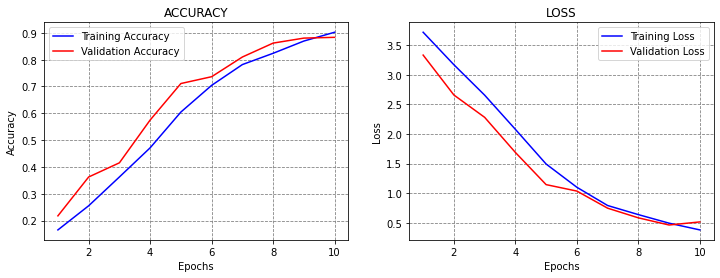

In [8]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 10

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-4, Epochs = 30

Let's train the model for 30 epochs using the same learning rate to see if this number of epochs would be sufficient. 

From the results we can see that the model achieved about 91.61% accruacy, and the training took about 6 minutes. 

Based on the learning curves, at epoch 30 the validation accuracy and loss were converging to a plateau level, and it was unclear if we trained the model for more than 30 epochs, the performance would have improved. An alternative is to use Early Stopping callback, so that the training is stopped automaticaly (e.g., when the validation loss stops decreasing). Such case is shown in the next section.


Training time: 0:05:39.578695
33/33 [==============================] - 1s 38ms/step - loss: 0.3680 - accuracy: 0.9161
Classification Accuracy:  91.61105751991272


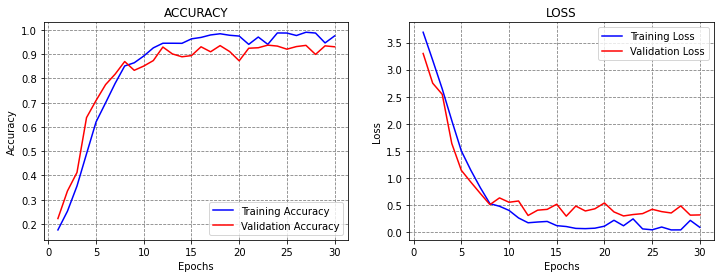

In [9]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 30

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-3, Epochs = 20

Next, let's try to train the model using different learning rates, for instance, by increasing the learning rate to `1e-3 = 0.001`.

Increasing the learning rate will cause the model to apply larger values for the update of the parameters during the training. We can expect that the training will converge faster, and we can use a smaller number of epochs. 

However, large learning rates can cause the model to update the parameters too fast, as in this case. As we can see, the model achieved only 16.87% accuracy, and the accuracy curves did not improve after that level.


Training time: 0:03:35.263105
33/33 [==============================] - 1s 37ms/step - loss: 3.7223 - accuracy: 0.1687
Classification Accuracy:  16.873212158679962


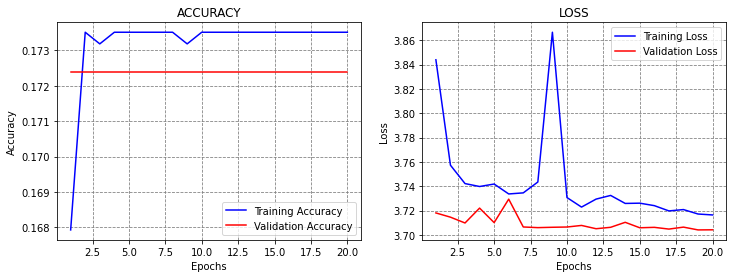

In [10]:
LEARNING_RATE = 1e-3
EPOCHS_NUM = 20

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-2, Epochs = 10

If we increase the learning rate even further to `0.01`, we can expect that training will fail, since we say that even a learning rate of `0.001` was too high. Based on the learning curves, we can tell that the learning is too fast and too aggressive.


Training time: 0:01:46.387700
33/33 [==============================] - 1s 36ms/step - loss: 3.7226 - accuracy: 0.1687
Classification Accuracy:  16.873212158679962


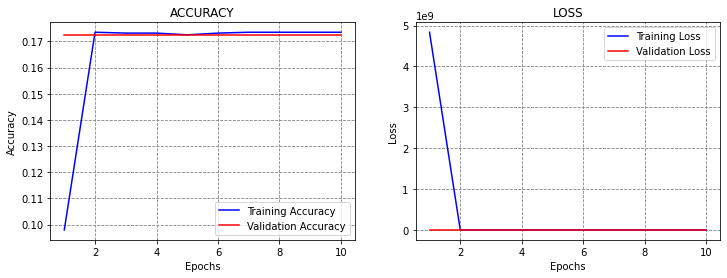

In [11]:
LEARNING_RATE = 1e-2
EPOCHS_NUM = 10

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-5, Epochs = 50

Let's try the opposite case, and reduce the learning rate to `1e-5 = 0.00001`. Smaller learning rates produce smaller updates of the model parameters, and slower learning. This may avoid the problems of too fast learning when large learning rates are used.

This model achieved 94.37% accuracy, which is higher than the accuracy with the `1e-4` learning rate. Also, the learning curves look good, because the accuracy and loss gradualy change, and the validation curves follow the training curves. 




Training time: 0:09:27.684121
33/33 [==============================] - 1s 38ms/step - loss: 0.2719 - accuracy: 0.9438
Classification Accuracy:  94.37559843063354


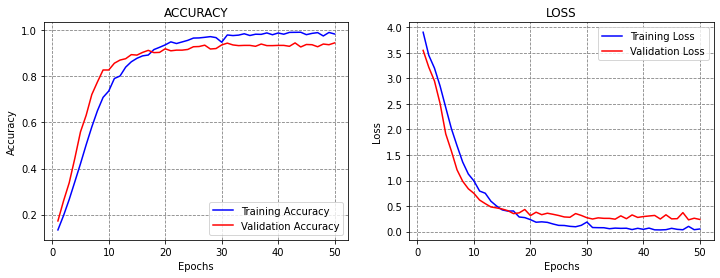

In [12]:
LEARNING_RATE = 1e-5
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-6, Epochs = 50

Next, let's reduce the learning rate even further to `1e-6`. 

Although smaller learning rate avoid the training failure when we used overly large learning rates, using very small learning rates does not necessarily leads to improved performance, since the learning can be too slow. 

Based on the learning curves, we can tell that at the end of epoch 50 the model parameters were going through significant updates, and that with this learning rate we would need to train the model for at least 2-300 epochs to reach convergence. 


Training time: 0:09:25.480266
33/33 [==============================] - 1s 38ms/step - loss: 1.4210 - accuracy: 0.6883
Classification Accuracy:  68.82745623588562


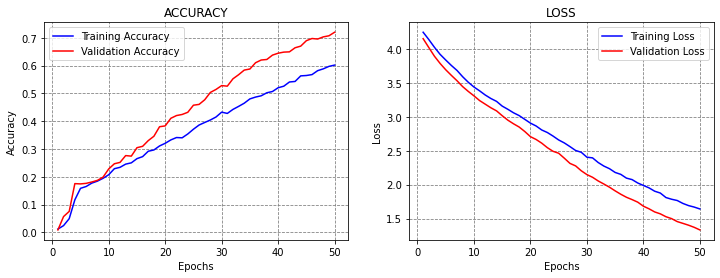

In [13]:
LEARNING_RATE = 1e-6
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

<a name='section2-1'></a>

## 21.2.1 Learning Rate Finder

In [ ]:
!git clone https://github.com/WittmannF/LRFinder.git

Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [ ]:
from LRFinder.keras_callback import LRFinder

Epoch 1/2
 6/96 [>.............................] - ETA: 11s - loss: 4.1732 - accuracy: 0.0000e+00

96/96 [==============================] - 36s 122ms/step - loss: 4.1457 - accuracy: 0.0214
Epoch 2/2
96/96 [==============================] - 12s 120ms/step - loss: 3660.4465 - accuracy: 0.0796


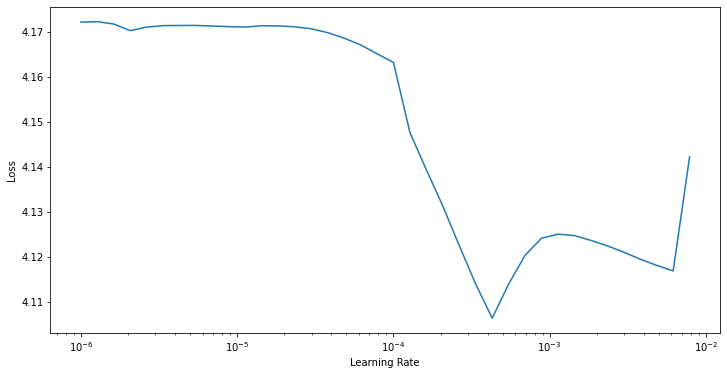

In [ ]:
model = Network()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform the Learning Rate Range Test
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2)

model.fit(imgs_train, labels_train, batch_size=32, callbacks=[lr_finder], epochs=2)

<a name='section3'></a>

# 21.3 Callbacks

### Early Stopping Callback

As we know, using Early Stopping callback is often beneficial, since we don't need to guess the optimal number of epochs to train the model. Instead, the callback will terminate the training when a selected metric is not improving. In the next cell, we specified to stop the training when the validation loss does not imrprove for a 20 epochs (`patience` argument). We set the EPOCH_NUM to 1000, although we know that the model will terminate after about 50-60 epochs. Therefore, the number of epochs is not very important when we use this callback, it is only important to be large enough.

This model achieved 91.13% accuracy. Howover, from the accuracy curve it seems that the accuracy was higher in the previous epoch, and it just dropped in the last epoch. We will see later how we can avoid this by using CheckPoint callback.


Training time: 0:08:28.139167
33/33 [==============================] - 1s 38ms/step - loss: 0.4212 - accuracy: 0.9113
Classification Accuracy:  91.13441109657288


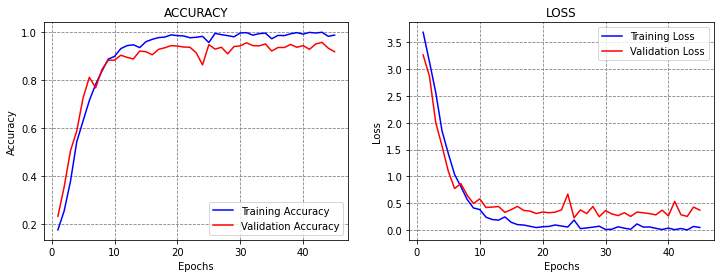

In [14]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 1000

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience=20)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### CheckPoint Callback

***CheckPoint*** callback saves a checkpoint of the model after every epoch when a monitored metric does not improve. We set the metrics to be the validation loss, and the values of the model parameters will be saved at the specified `filepath`. This can be useful if training the model takes hours, where if something goes wrong, we can just resume the training from a checkpoint. 

We choose to set `verbose=1` for the callback, so that the output will print each epoch at which a checkpoint is saved. Also note this setting will overwrite the checkpoint when there is improvement.

At the beginning of the training, the checkpoint will be saved after every epochs, and after the model reaches a plateau, a new checkpoint will be saved only when there is improvement in the perfromance. 



Epoch 1: saving model to sample_data/model_celeb.h5

Epoch 2: saving model to sample_data/model_celeb.h5

Epoch 3: saving model to sample_data/model_celeb.h5

Epoch 4: saving model to sample_data/model_celeb.h5

Epoch 5: saving model to sample_data/model_celeb.h5

Epoch 6: saving model to sample_data/model_celeb.h5

Epoch 7: saving model to sample_data/model_celeb.h5

Epoch 8: saving model to sample_data/model_celeb.h5

Epoch 9: saving model to sample_data/model_celeb.h5

Epoch 10: saving model to sample_data/model_celeb.h5

Epoch 11: saving model to sample_data/model_celeb.h5

Epoch 12: saving model to sample_data/model_celeb.h5

Epoch 13: saving model to sample_data/model_celeb.h5

Epoch 14: saving model to sample_data/model_celeb.h5

Epoch 15: saving model to sample_data/model_celeb.h5

Epoch 16: saving model to sample_data/model_celeb.h5

Epoch 17: saving model to sample_data/model_celeb.h5

Epoch 18: saving model to sample_data/model_celeb.h5

Epoch 19: saving model to sample_dat

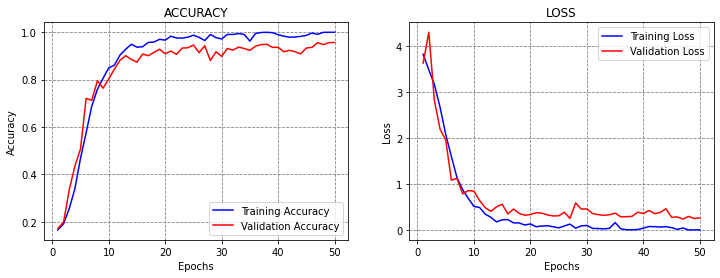

In [15]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = ModelCheckpoint(filepath='sample_data/model_celeb.h5', monitor='val_loss', save_weights_only=True, verbose=1)
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=[callbacks])
print('Training time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### ReduceLROnPlateau Callback

***ReduceLROnPlateau*** stands for Reduce Learning Rate on Plateau. It is another very usefull callback, since prior works have reported that training models generally benefits from using larger learning rate at the beginning of the trining, and gradually reducing the learning rate when the training does not improve. 

This is exactly what this callback does. In the next call, the learning rate is initially set to `1e-4=0.0001`. ReduceLROnPlateau has a patience of 10 epochs, factor of 0.1, and minimum learning rate of `1e-6`. This means that when the monitored metric (in this case, the validation loss) does not reduce for 10 epochs, the learning rate will be multipied by the `factor` and become `1e-5`. When the model stop improving again, the learning rate will be again mutliplied by the factor and become `1e-6`. Since this is the minimum value for the learning rate, we will combine this callback with Early Stopping to terminate the training. Note that the patience values for the Early Stopping was set longer that the one for the ReduceLROnPlateau.



Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-06.

Training time: 0:10:10.307770
33/33 [==============================] - 1s 39ms/step - loss: 0.3501 - accuracy: 0.9466
Classification Accuracy:  94.66158151626587


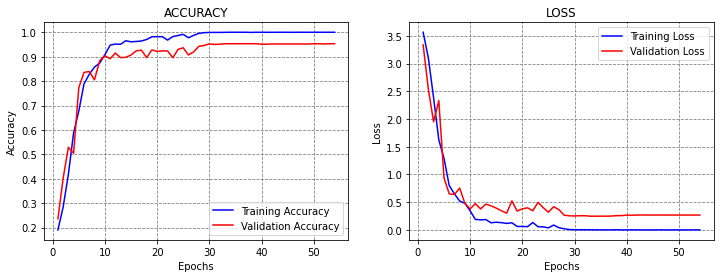

In [16]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 1000

model = Network()
model.compile(optimizer=Adam(learning_rate = LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience = 20),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM, 
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", 100*evals_test[1])


# plot the accuracy and loss
plot_accuracy_loss()

<a name='section4'></a>

# 21.4 Grid Search

Applying Grid Search over hyperparameters of neural networks models that have long training time can be prohibitively computationaly expensive. On the other hand, when working with smaller datasets and models, applying Grid Search for some of the hyperparameters can be an option. 

This section present a simple Grid Search over the number o


In [17]:
def Network(neurons_per_layer, batch_size):

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
      
    x = Dense(neurons_per_layer, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer
    predictions = Dense(62, activation='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile
    model.compile(optimizer=Adam(learning_rate=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    # Fit
    model.fit(imgs_train, labels_train, batch_size=batch_size, epochs=30, 
                     validation_data=(imgs_val, labels_val), verbose=0)
    
    # Evaluate on test data
    _, test_acc = model.evaluate(imgs_test, labels_test)

    return test_acc

In [18]:
neurons_per_layers = [512, 1024, 2048]
batch_sizes = [32, 64, 128]

for number_neurons in neurons_per_layers:
    for batch_size in batch_sizes:
        acc = Network(number_neurons, batch_size)
        print('\nNumber of neurons', number_neurons, 
                '\tBath size', batch_size,
                '\tTest accuracy', acc)

33/33 [==============================] - 1s 38ms/step - loss: 0.3991 - accuracy: 0.9218

Number of neurons 512 	Bath size 32 	Test accuracy 0.9218302965164185
33/33 [==============================] - 1s 38ms/step - loss: 0.4094 - accuracy: 0.9171

Number of neurons 512 	Bath size 64 	Test accuracy 0.9170638918876648
33/33 [==============================] - 1s 38ms/step - loss: 0.3639 - accuracy: 0.9399

Number of neurons 512 	Bath size 128 	Test accuracy 0.9399427771568298
33/33 [==============================] - 1s 38ms/step - loss: 0.3111 - accuracy: 0.9352

Number of neurons 1024 	Bath size 32 	Test accuracy 0.9351763725280762
33/33 [==============================] - 1s 38ms/step - loss: 0.3525 - accuracy: 0.9342

Number of neurons 1024 	Bath size 64 	Test accuracy 0.9342230558395386
33/33 [==============================] - 1s 38ms/step - loss: 0.3102 - accuracy: 0.9466

Number of neurons 1024 	Bath size 128 	Test accuracy 0.9466158151626587
33/33 [==============================] - 

<a name='section5'></a>

# 21.5 Keras Tuner

There are several libraries that have been developed to tune the hyperparameters of neural networks. One is the ***Keras Tuner***, devloped for hyperparameter tuning with Keras models. 

The tuner is similar to the Grid Search in scikit-learn, and allows to define the search space for the hyperparameters over which the model will be fit, and it returns an optimial set of hyperparameters. 

Keras Tuner is not part of the `Keras` package and it needs to be installed and imported. 

In [20]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 29.9 MB/s 
     |████████████████████████████████| 1.6 MB 56.6 MB/s 


In [21]:
import keras_tuner as kt

### Load MNIST Dataset

To demonstrate the use of the Keras Tuner we will work with the MNIST dataset. 

In [22]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4422102/4422102 [==============================] - 0s 0us/step


### Model Builder

When defining the neural network with the Keras Tuner, the range of the values for the hyperparameters of interest will be specified. Such a model is called a ***hypermodel***.

In the cell below, a function called `model_biilder` is created, which performs search over two hyperparameters:

- Number of neurons in the first Dense layer,
- Learning rate. 

The line `hp_units = hp.Int('units', min_value=32, max_value=512, step=32)` defines a grid search for the number of neurons in the Dense layer in the range [32, 64, 96, ..., 512].

Next, a grid search for the learning rate is defined in the rane `[1e-2, 1e-3, 1e-4]`.

In [23]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

# Hyperparameter Tuning

Next, the tuner is instantiated for the hyerparamter tuning. 

The Keras Tuner has four tuners available: 

- RandomSearch Tuner, similar to the Random Grid in scikit-learn performs a random search over a distribution of values for the hyperparameters.
- Hyperband Tuner, trians a large number of models for a few epochs and carries forward only the top-performing half of models to the next round, to converge to a high-performing model. 
- BayesianOptimization Tuner, performs BayesianOptimization tuning with Gaussian process.
- Sklearn Tuner, desined for use with scikit-learn models.

In the next cell the Hyperband tuner is used, which has as the arguments the model, objective (metric) to monitor, the number of epochs, and factor (used for the search of top-performing models).

In [24]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [26]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 30 Complete [00h 00m 33s]
val_accuracy: 0.8552500009536743

Best val_accuracy So Far: 0.8865833282470703
Total elapsed time: 00h 09m 32s


In [28]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")

Optimal number of neuron in the Dense layer: 480
Optimal learning rate: 0.001


### Train and Evaluate the Model

Next, we will use the optimal hyperparameters from the Keras Tuner to create a model, and afterward we will evaluate the accuracy on the test dataset. 


In [30]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(img_train, label_train, epochs=50, validation_split=0.2, verbose=0)

eval_result = model.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.5827 - accuracy: 0.8874
[test loss, test accuracy]: [0.5827264189720154, 0.8873999714851379]


<a name='section10'></a>

# References

1. TensorFlow - ML Basics with Keras, Introduction to the Keras Tuner, available at [https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning.](https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning.).

[BACK TO TOP](#section0)